# Zastosowanie wielomianów ortogonalnych w medycynie obliczeniowej
#### Autor: dr inż. Katarzyna Rycerz

## Wielomiany ortogonalne - teoria

W przestrzeni wielomianów rzeczywistych dowolnego stopnia określonych na przedziale $[a,b]$ możemy wprowadzić następującą definicję iloczynu skalarnego:

$$\langle P_n,P_m\rangle=\int_a^b P_n(x)P_m(x)\omega(x)dx$$

gdzie funkcja $\omega$ jest nazywana *funkcją wagową* lub po prostu *wagą*.

Normą pochodzącą od tego iloczynu skalarnego jest

$$\|P_n\|=\sqrt{\langle P_n,P_n\rangle}=\left(\int_a^b P_n^2(x)\omega(x)dx\right)^{\frac{1}{2}}$$

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch różnych wielomianów jest równy 0.

Jeżeli dodatkowo norma każdego wielomianu (czyli jego iloczyn skalarny przez siebie) jest równa 1, to nazywamy je **wielomianami ortonormalnymi.**

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:
$$\begin{aligned}H_0(x) &= 1\\H_1(x) &= 2x\\H_{n+1}(x) &= 2xH_n(x)-2nH_{n-1}\end{aligned}$$
albo wzorem Rodriguesa: 
$$H_{n}(x)=(-1)^{n}e^{x^{2}}{\frac {d^{n}}{dx^{n}}}e^{-x^{2}}.$$

W `scipy` wielomiany Hermite'a znajdziemy w bibliotece `special`: `scipy.special.hermite(n, monic=False)`, gdzie `n` to żądany stopień wielomianu. W przypadku `monic=True` otrzymany wielomian zostanie przeskalowany tak, aby współczynnik wiodący (przy najwyższej potędze) był równy 1. Obiektem zwracanym jest wielomian specjalnej klasy `orthopoly1d`, którego używamy jak normalnego wielomianu `poly1d`.

Wykres przykładowego wielomianu (tutaj 3 stopnia)

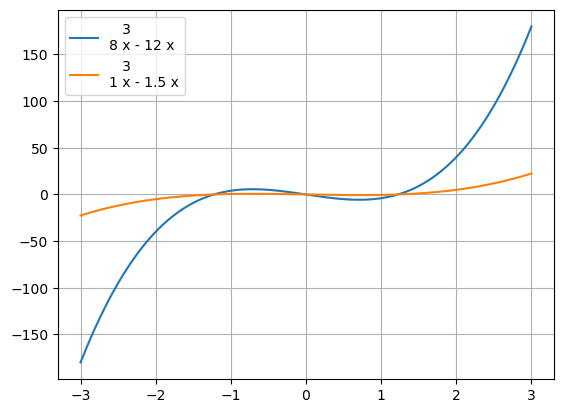

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special

p_herm = special.hermite(3)
p_monic = special.hermite(3, monic=True)


x = np.linspace(-3, 3, 400)


plt.plot(x, p_herm(x))
plt.plot(x,p_monic(x))
plt.legend([p_herm,p_monic])
plt.grid()
plt.show()

W bibliotece `numpy` również mamy moduł dla wielomianów Hermite'a.

0.0 + 0.0·H₁(x) + 0.0·H₂(x) + 1.0·H₃(x)
[  0. -12.   0.   8.]


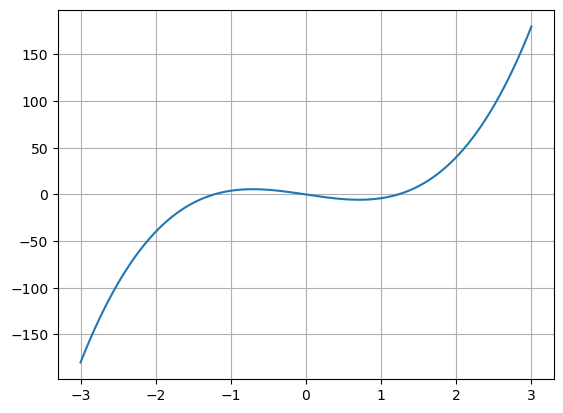

In [27]:
from numpy.polynomial import hermite
from numpy.polynomial.polynomial import Polynomial

x = np.linspace(-3, 3, 400)

HS3=hermite.Hermite([0,0,0,1]) #współczynniki szeregu Hermite'a, od wyrazu wolnego
print(HS3)

H3=hermite.herm2poly([0,0,0,1]) #postać wielomianowa otrzymanego szeregu Hermite'a,
                                #czyli wielomian Hermitte'a stopnia 3
print(H3)

plt.plot(x, Polynomial(H3)(x))
plt.grid()
plt.show()

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [19]:
# Definicja węzłów - zaszumiony cosinus
xx = np.arange(-5,5,0.1)
yy = np.cos(xx/3 + .2)**2 + np.random.rand(len(xx))/5

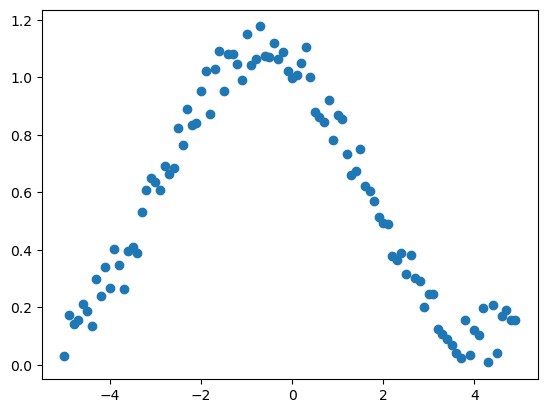

In [20]:
plt.scatter(xx, yy)

Jak to zrobić w `numpy`:

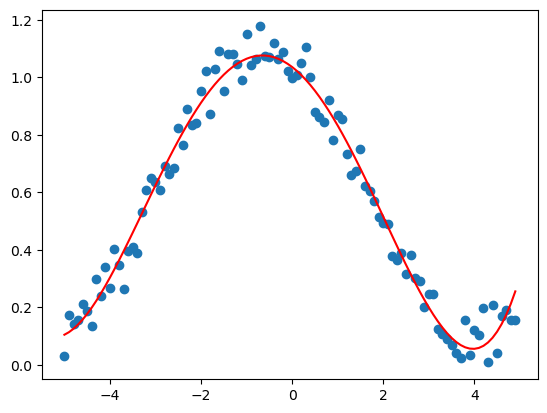

In [31]:
HFS4=hermite.hermfit(xx,yy,4)  #znalezienie współczynników szeregu Hermite'a

HF4=hermite.herm2poly(HFS4)  #postać wielomianowa otrzymanego szeregu

plt.scatter(xx, yy)
plt.plot(xx, Polynomial(HF4)(xx),'r')

plt.show()

### Algorytm aproksymacji krok po kroku

#### Krok 1.

* 0bliczamy funkcję bazową uwzględniającą funkcję wagową $\exp(-x^2)$.
$$\langle H_n,H_m\rangle=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy, tzn. dzielimy współczynniki przez jego długość w normie Euklidesowej.


In [15]:
#przykład prostego wektora, który znormalizujemy
vec = np.array([2,2,2,2])
vec

array([2, 2, 2, 2])

In [16]:
# norma wektora
norm = np.linalg.norm(vec)
norm

4.0

In [17]:
# normalizacja - dzielimy przez normę
vec=vec/norm
vec

array([0.5, 0.5, 0.5, 0.5])

In [18]:
# sprawdzamy długość
np.linalg.norm(vec)

1.0

Funkcja obliczająca funkcje bazowe z kroku 1.

In [53]:
def base_fun(x,k,norm=True):
    '''
    compute values of k-th base function on values x
    if norm=True returns normalised vector
    '''
    idx = np.zeros(k+1)
    idx[k] = 1
    Hk = hermite.herm2poly(idx)
    fun = Polynomial(Hk)(x)* np.exp(-(x**2)/2)
    if norm:
        fun = fun/np.linalg.norm(fun)
    return fun

Różnica między drugą funkcją bazową z i bez normalizacji a drugim wielomianem Hermite'a.

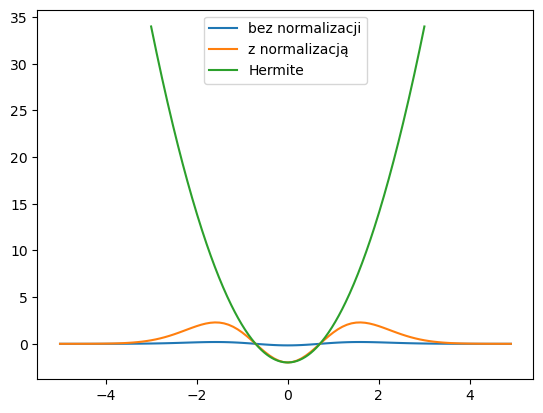

In [54]:
plt.plot(xx,base_fun(xx,2))
plt.plot(xx,base_fun(xx,2,False))
plt.plot(x, Polynomial(hermite.herm2poly([0,0,1]))(x))
plt.legend(['bez normalizacji',"z normalizacją",'Hermite'])

#### Krok 2.

Obliczamy wektory wartości dla punktów w `xx` dla kilku kolejnych funkcji bazowych.

In [69]:
base = np.array([base_fun(xx,k) for k in range(4)])
base

array([[ 8.85179827e-07,  1.45213595e-06,  2.35852292e-06,
         3.79253833e-06,  6.03777484e-06,  9.51657999e-06,
         1.48505298e-05,  2.29435199e-05,  3.50941883e-05,
         5.31456119e-05,  7.96813487e-05,  1.18277734e-04,
         1.73822652e-04,  2.52910467e-04,  3.64321070e-04,
         5.19587662e-04,  7.33652542e-04,  1.02560252e-03,
         1.41946531e-03,  1.94503556e-03,  2.63868388e-03,
         3.54408587e-03,  4.71279081e-03,  6.20453366e-03,
         8.08718137e-03,  1.04361972e-02,  1.33335079e-02,
         1.68656711e-02,  2.11212631e-02,  2.61874493e-02,
         3.21457504e-02,  3.90670836e-02,  4.70062354e-02,
         5.59960001e-02,  6.60412972e-02,  7.71136464e-02,
         8.91464266e-02,  1.02031364e-01,  1.15616683e-01,
         1.29707285e-01,  1.44067258e-01,  1.58424836e-01,
         1.72479823e-01,  1.85913267e-01,  1.98399021e-01,
         2.09616624e-01,  2.19264828e-01,  2.27074978e-01,
         2.32823408e-01,  2.36342083e-01,  2.37526753e-0

Sprawdźmy czy otrzymana w ten sposób baza jest ortonormalna (uwaga: zamiast liczyć całkę, liczymy po prostu iloczyn skalarny wektorów wartości. Jeśli wartości są wystarczająco "gęsto" jest do dobre przybliżenie).

In [64]:
dot_base = np.array([x.dot(y).round(5) for x in base for y in base]).reshape(4,4)
print(dot_base)

[[ 1. -0. -0. -0.]
 [-0.  1. -0. -0.]
 [-0. -0.  1. -0.]
 [-0. -0. -0.  1.]]


#### Krok 3.

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektory bazowe są znormalizowane, co upraszcza obliczenia.

In [66]:
coeffs = np.array([yy.dot(f) for f in base])
coeffs

array([ 5.68804074, -0.97610284,  2.70892675, -0.84095341])

Liczymy wartości aproksymowane kolejnymi stopniami

In [76]:
y_app = np.array([coeffs[k]*base[k] for k in range(4)])
y_app_c = np.cumsum(y_app,axis=0)

y_app_c

array([[ 5.03493892e-06,  8.25980844e-06,  1.34153744e-05,
         2.15721126e-05,  3.43431093e-05,  5.41306948e-05,
         8.44704185e-05,  1.30503676e-04,  1.99617173e-04,
         3.02294406e-04,  4.53230758e-04,  6.72768572e-04,
         9.88710329e-04,  1.43856504e-03,  2.07227309e-03,
         2.95543579e-03,  4.17304555e-03,  5.83366890e-03,
         8.07397654e-03,  1.10634415e-02,  1.50089414e-02,
         2.01589048e-02,  2.68065461e-02,  3.52916403e-02,
         4.60002171e-02,  5.93615148e-02,  7.58415364e-02,
         9.59326245e-02,  1.20138605e-01,  1.48955279e-01,
         1.82846338e-01,  2.22215163e-01,  2.67373382e-01,
         3.18507530e-01,  3.75645589e-01,  4.38625563e-01,
         5.07068507e-01,  5.80358558e-01,  6.57632403e-01,
         7.37780324e-01,  8.19460434e-01,  9.01126923e-01,
         9.81072260e-01,  1.05748224e+00,  1.12850172e+00,
         1.19230790e+00,  1.24718728e+00,  1.29161172e+00,
         1.32430903e+00,  1.34432340e+00,  1.35106185e+0

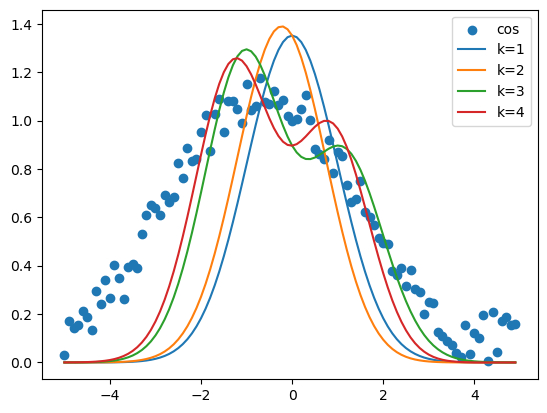

In [79]:
plt.scatter(xx,yy)
plt.plot(xx,y_app_c[0])
plt.plot(xx,y_app_c[1])
plt.plot(xx,y_app_c[2])
plt.plot(xx,y_app_c[3])
plt.legend(['cos','k=1','k=2','k=3','k=4'])

Liczymy błędy aproksymacji kolejnymi stopniami

In [81]:
from sklearn.metrics import mean_squared_error as mse

for k in range(4):
    print(f'MSE dla k={k+1} wynosi {mse(yy,y_app_c[k])}')


MSE dla k=1 wynosi 0.13395434262800676
MSE dla k=2 wynosi 0.1244265750227455
MSE dla k=3 wynosi 0.0510437337309427
MSE dla k=4 wynosi 0.043971707473245074


### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [91]:
import pandas as pd

ekg_data = pd.read_csv("ecg_data.csv",sep=';')
ekg_data

,time,signalN,signalV
0,-0.100000,0.018389,-0.099097
1,-0.097222,0.014519,-0.092044
2,-0.094444,0.012849,-0.083164
3,-0.091667,0.012495,-0.072273
4,-0.088889,0.012412,-0.059366
...,...,...,...
68,0.088889,-0.012009,-0.102289
69,0.091667,-0.013447,-0.038071
70,0.094444,-0.014823,0.021100
71,0.097222,-0.015987,0.073348


<Axes: xlabel='time'>

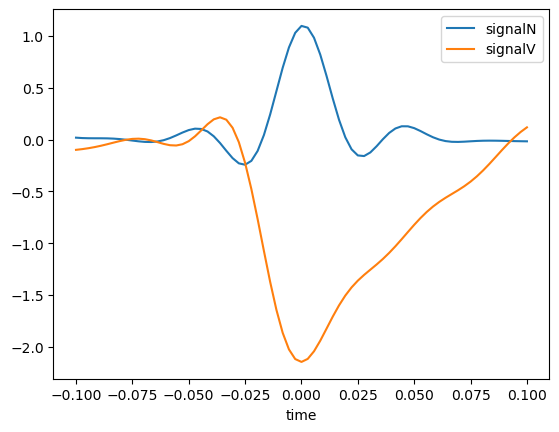

In [96]:
ekg_data.plot('time',['signalN','signalV'])

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [98]:
# Definicja węzłów
xx_ekg = np.array(ekg_data['time']*40)
yy_ekgV = np.array(ekg_data['signalV'])

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

Podobnie  narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

#### Zadanie 3  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 4  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?